<a href="https://colab.research.google.com/github/Prukutu/example-notebooks/blob/main/Workshop_LGACC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Let's set up the environment. You only need to run this if you're running the
# notebook on Google Colaboratory. Otherwise just install packages as you 
# normally would.
!pip install geopandas
!pip install seaborn
!pip install geopandas
!pip install mapclassify
!pip install libpysal
!pip install esda

# Let's explore multi-hazard risk in NYC using spatial exploratory analysis
We will use the local indicators of spatial autocorrelation to find cold and hot spots of multihazard risk to COVID-19 and heat in NYC.

This Notebook replicates portions of the work presented in Ortiz et al (2022) article on COVID-19 and extreme heat.

In [ ]:
# Import packages

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

import libpysal as lps
import esda
import mapclassify as mc

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We need to "mount" the google drive to access the data
# f = open('/content/drive/My Drive/Colab Notebooks/data/risks_v2.shp')

# Load the risk data. This "shapefile" defines a series of boundaries.
# Each boundary has a set of attributes defining 
df = gpd.read_file('/content/drive/My Drive/Colab Notebooks/data/risks_v2.shp')

# Define our variable names from the shapefile
heat = 't2norm'
covid = 'case_raten'
risk = 'risk'

# Nans belong to parks or uninhabited areas so convert to zero
df['risk'] = df['risk'].replace(np.nan, 0)


Let's look at what's in the shapefile. Opening a file with geopandas (as we did here) returns a **GeoDataframe** object. This object encodes both the geometry and attributes of the shapefile we read in the previous cell. 

GeoDataframes can be thought of as a table, where each column is an *attribute* of the data, and each row is a different *feature*. A *feature* consists of a boundary, as defined by geometry (itself defined by a collection of points. An *attribute* describes some property of that boundary (for example: how many people in this zip code?)

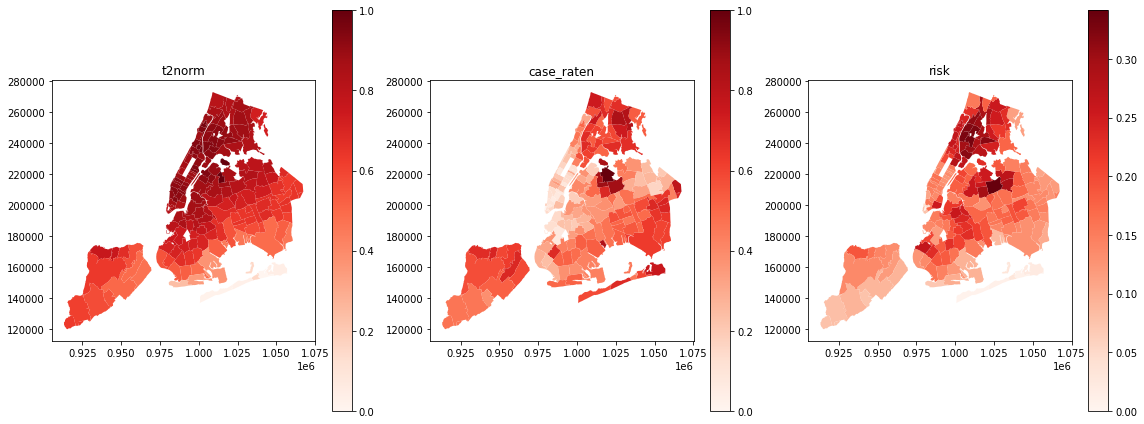

In [ ]:


fig, axes = plt.subplots(1, 3, tight_layout=True, figsize=(16, 6))

# Try different colormaps for the data. Matplotlib has several pre-defined colormaps 
# For a list and explanation of colormaps (with some color perception theory thrown
# in) check out their documentation: 
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

# Colormaps can be changed with the cmap keyword argument in the .plot method
for n, variable_name in enumerate([heat, covid, risk]):
  df.plot(column=variable_name, 
          ax=axes[n], 
          legend=True,
          cmap='Reds')
  # Setting a title for our plots so we know what's what.  
  axes[n].set_title(variable_name)

plt.show()

In spatial autocorrelation analysis, **spatial weights** are used to describe the notion of spatial similarity in our data. They tell us a bit about how connected various points in our data are (how many *neighbors*, how close they are to each other, etc).

There are several methods to compute spatial weights. Here we use the Queens method. The **Queen** connectivity considers neighbors that are connected to a geometry either along an *edge* or a *vertex*. Another option is **Rook** connectivity, which only considers neighbors that are connected on a geometry's *edge*. 

In [ ]:
# Get spatial weights
wq = lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

# Remove islands from dataset and recompute weights
df = df.drop(wq.islands)
wq = lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'


/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There is 1 island with id: 37.
  warnings.warn(message)


('WARNING: ', 37, ' is an island (no neighbors)')


/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


Let's explore the spatial structure of our data. First, we create a spatial lag. A **spatial lag** is a measure how similar attributes of one location are to neighboring ones.

In [ ]:
y = df[risk]

# Plot the Moran Scatter plot
lag_risk = lps.weights.lag_spatial(wq, df['risk'])

# Linear fit. This will be useful when we want to plot everything together.
b, a = np.polyfit(df['risk'], lag_risk, 1)


Now, let's draw a plot of the spatial lag against the value at each location

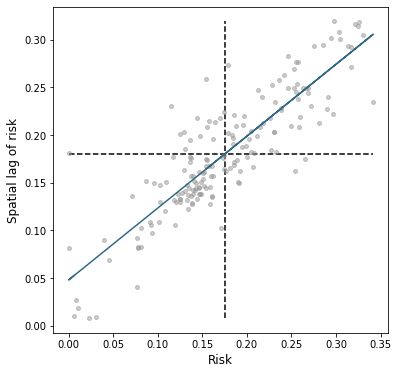

In [ ]:
f, ax = plt.subplots(1, figsize=(6, 6))


plt.plot(df['risk'],
         lag_risk,
         marker='.',
         linestyle='none',
         color='#999899',
         markersize=8,
         alpha=0.5)

 # dashed vertex at mean of the df['risk']
plt.vlines(df['risk'].mean(),
           lag_risk.min(),
           lag_risk.max(),
           linestyle='--',
           color='#000000')
 # dashed horizontal at mean of lagged price
plt.hlines(lag_risk.mean(),
           y.min(),
           df['risk'].max(),
           linestyle='--',
           color='#000000')
plt.plot(df['risk'],
         a + b*df['risk'],
         color='#336985')

ax.set_ylabel('Spatial lag of risk', fontsize=12)
ax.set_xlabel('Risk', fontsize=12)
# f.savefig('moranscatter_v2.png', dpi=200)


plt.show()

We call this diagram the **Moran Scatterplot**. We can derive an indicator of spatial autocorrelation as the slope of the linear fig of the data above. That indicator is called the Moran's I and gives a sense of how spatially autocorrelated our data might be.

The Moran Scatterplot is useful, because it lets us divide our data into hot and cold spots. Points that lie to the right of the mean (the *verticle dashed line*) are *high*, and values to the left are considered *low*. Values above the horizontal dashed line have *positive* spatial autocorrelation, while values below it have *negative* spatial autocorrelation. 

With this information, we can divide our data into *four quadrants*. Data with high values and positive spatial autocorrelation (upper right corner, high-high) are considered **hot spots**. The lower left area has low values and positive autocorrelation and is considered a **cold spot**. 

The **slope** of the linear fit above is a useful indicator called the Moran's I and it's useful to assign the quadrant values to our data automatically. Thankfully, the ESDA package has a method to calculated it easily.

In [ ]:
li = esda.moran.Moran_Local(y, wq, permutations=9999)
mi = moran = esda.moran.Moran(y, wq, permutations=9999)

siglev = 0.05
sig = 1 * (li.p_sim < siglev)
hotspot = 1 * (sig * li.q==1)
coldspot = 2 * (sig * li.q==3)
# doughnut = 2 * (sig * li.q==2)
# diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot
# spot_labels = [ 'No Significance', 'Hot Spot', 'Cold Spot', 'dough', 'diamond']

spot_labels = ['No significance', 'Hot spot', 'Cold spot']

labels = [spot_labels[i] for i in spots]


In [ ]:
# Finally we create a new plot to see our hot and cold spots.

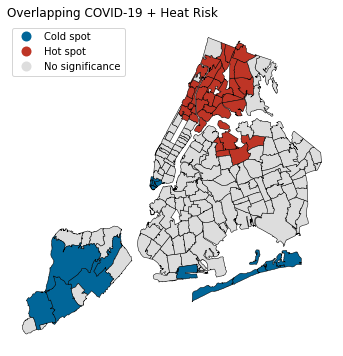

In [ ]:
df['cl'] = labels
# df['colors'] = [colors[cat] for cat in df['cl'].values]
df['spots'] = spots

# Create a colormap
hmap = colors.ListedColormap(['#016699', '#BE3526', '#DDDDDD'])


f, ax = plt.subplots(1, figsize=(6, 6))

leg_kwarg = {'loc': 'upper left',
             'fontsize': 10}
df.plot(column='cl',
        categorical=True,
        k=3,
        cmap=hmap,
        # color=df['colors'],
        linewidth=0.5,
        ax=ax,
        edgecolor='black',
        legend=True,
        legend_kwds=leg_kwarg
        )

ax.set_title('Overlapping COVID-19 + Heat Risk',
             fontsize=12,
             loc='left')
ax.set_axis_off()

# For more on Geopandas, Matplotlib, and spatial analysis in python:

https://matplotlib.org/stable/tutorials/index

https://geopandas.org/en/stable/getting_started.html

https://geodacenter.github.io/workbook/5a_global_auto/lab5a.html
